In [35]:
import os

import numpy as np
import pandas as pd
import json
import cv2
from sklearn.model_selection import train_test_split
import cv2

# tf imports
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras import backend as K

In [36]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPU


loading images with labels

In [37]:
f = open("..\data\measurements.json")
data_json = json.loads(f.read())["Measurements"]

vs = data_json.values()

df = pd.json_normalize(vs)

df.head()


,Variety,RGB_Image,Depth_Information,FreshWeightShoot,DryWeightShoot,Height,Diameter,LeafArea
0,Lugano,RGB_27.png,Depth_27.png,5.5,0.42,9.0,11.0,153.9
1,Lugano,RGB_79.png,Depth_79.png,30.3,1.92,8.8,20.2,582.3
2,Lugano,RGB_140.png,Depth_140.png,60.9,2.83,11.6,19.0,960.6
3,Lugano,RGB_203.png,Depth_203.png,112.0,5.76,11.0,22.0,1614.9
4,Lugano,RGB_292.png,Depth_292.png,372.6,14.17,17.0,32.0,3839.6


In [38]:
import albumentations as alb

def augment(train_set, train_labels, iterations):
    # Define a list of image augmentation transformations to apply
    aug_transforms = [
        alb.HorizontalFlip(),
        alb.VerticalFlip(),
        alb.RandomRotate90(),
        alb.Transpose(),
        alb.RandomBrightnessContrast()
    ]

    # Use the Compose function to apply the transformations
    aug = alb.Compose(aug_transforms)

    # Set the number of times to augment the images
    num_augmentations = iterations

    # Iterate through the number of augmentations
    for i in range(num_augmentations):
      # Iterate through your training set and apply the augmentations to each image
      augmented_train_set = []
      augmented_train_labels = []
      for image, label in zip(train_set, train_labels):
        augmented_image = aug(image=image)['image']
        augmented_train_set.append(augmented_image)
        augmented_train_labels.append(label)

      # Add the augmented images and labels to the training set
      train_set = np.concatenate((train_set, augmented_train_set))
      train_labels = np.concatenate((train_labels, augmented_train_labels))

    # Shuffle the training set and labels
    p = np.random.permutation(len(train_set))
    X = train_set[p]
    y = train_labels[p]
    return X, y


In [69]:
"""
    number: depth=0, RGB=1, depth/RGB=2, augment_data: amount of times for data to be augmented
"""
def prepare_data(number=0, y_key='Height', augment_data=0, normalized = True):

    all_images = []
    y = []

    if number == 2:
        path_RGB = '../data/RGBImagesResize/'
        key_RGB = 'RGB_Image'
        flag_RGB = cv2.IMREAD_COLOR

        path_depth = '../data/DepthImagesResize/'
        key_depth = 'Depth_Information'
        flag_depth = cv2.IMREAD_GRAYSCALE

        for image_path_RGB in os.listdir(path_RGB):
            if df.loc[df[key_RGB] == image_path_RGB][y_key].size > 0:
                img_ID = image_path_RGB.strip(".png").strip("RGB_")
                y.append(df.loc[df[key_RGB] == image_path_RGB][y_key].item())
                img_RGB = cv2.imread(path_RGB + image_path_RGB, flag_RGB)
                img_RGB = cv2.resize(img_RGB, (250, 250))
                image_path_depth = path_depth + "Depth_"+ img_ID + ".png"
                img_depth = cv2.imread(image_path_depth, flag_depth)
                img_depth = cv2.resize(img_depth, (250,250))
                if normalized:
                    img_RGB = img_RGB.astype(np.float32) / 255.0
                    img_depth = img_depth.astype(np.float32) / 255.0

                img_combined = np.dstack((img_RGB, img_depth))
                all_images.append(img_combined)
    else:
        if number == 1:
            path = '../data/RGBImagesResize/'
            key = 'RGB_Image'
            flag = cv2.IMREAD_COLOR
        else:
            path = '../data/DepthImagesResize/'
            key = 'Depth_Information'
            flag = cv2.IMREAD_GRAYSCALE

        for image_path in os.listdir(path):
            if df.loc[df[key] == image_path][y_key].size > 0:
                y.append(df.loc[df[key] == image_path][y_key].item())
                img = cv2.imread(path + image_path, flag)
                img = cv2.resize(img, (250, 250))
                if normalized:
                    img = img.astype(np.float32) / 255.0
                all_images.append(img)


    X_train, X_test, y_train, y_test = train_test_split(np.array(all_images), y, test_size=0.25, shuffle=True)

    if augment_data > 0:
        X_train, y_train = augment(X_train, y_train, augment_data)

    X_train = tf.convert_to_tensor(X_train)
    X_test = tf.convert_to_tensor(X_test)
    y_train = tf.convert_to_tensor(y_train)
    y_test = tf.convert_to_tensor(y_test)

    return X_train, y_train, X_test, y_test

ResNet Implementation for regression: depth images height

https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

!!LET OP NIET RUNNEN ZONDER GPU!!

In [40]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

In [41]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

In [42]:
def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides=(1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [43]:
def create_res_net(input_shape, regression):
    inputs = Input(shape=input_shape)
    num_filters = 64

    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)

    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j == 0 and i != 0), filters=num_filters)
        num_filters *= 2

    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(19, activation='softmax')(t)

    if regression:
        outputs = Dense(1, activation='linear')(t)

    model = Model(inputs, outputs)

    if regression:
        model.compile(
            optimizer='adam',
            loss='mean_squared_error',
            metrics=['mean_absolute_percentage_error']
        )
    else:
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import os

def fit_model(model, epochs, batch_size, X_train, y_train, X_test, y_test):
    timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    name = 'res_net'+timestr

    checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    os.system('mkdir {}'.format(checkpoint_dir))

    cp_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=0,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    tensorboard_callback = TensorBoard(
        log_dir=f'tensorboard_logs/{name}',
        histogram_freq=1
    )

    model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, y_test),
        batch_size=batch_size,
        callbacks=[cp_callback, tensorboard_callback]
    )

In [87]:
model = create_res_net((250,250,3),True)
X_train, y_train, X_test, y_test = prepare_data(1, 'DryWeightShoot', 1, True)
print(X_train.shape)
fit_model(model, 100, 16, X_train, y_train, X_test, y_test)

(580, 250, 250, 3)
Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node 'model_10/batch_normalization_313/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\joren\AppData\Local\Temp\ipykernel_33676\490320718.py", line 4, in <module>
      fit_model(model, 100, 16, X_train, y_train, X_test, y_test)
    File "C:\Users\joren\AppData\Local\Temp\ipykernel_33676\2957008618.py", line 32, in fit_model
      callbacks=[cp_callback, tensorboard_callback]
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\layers\normalization\batch_normalization.py", line 661, in _fused_batch_norm
      training, _fused_batch_norm_training, _fused_batch_norm_inference
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\utils\control_flow_util.py", line 109, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name
    File "C:\Users\joren\AppData\Roaming\Python\Python37\site-packages\keras\layers\normalization\batch_normalization.py", line 645, in _fused_batch_norm_training
      exponential_avg_factor=exponential_avg_factor,
Node: 'model_10/batch_normalization_313/FusedBatchNormV3'
OOM when allocating tensor with shape[16,128,125,125] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_10/batch_normalization_313/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_10064031]

## Plots predicted vs actual

In [76]:
def plot_true_vs_predicted(model, X, y, title):
    predicted = model.predict(X)
    actual = y
    plt.plot(actual, 'bo')
    plt.plot(predicted, 'r^')

    # Draw lines between the data points
    for x1, y1, x2, y2 in zip(range(len(actual)), actual, range(len(predicted)), predicted):
        plt.plot([x1, x2], [y1, y2], 'k-')

    plt.title(title)
    plt.legend(['True data', 'Predicted data'])
    plt.show()


Diameter

4/4 [==============================] - 2s 608ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


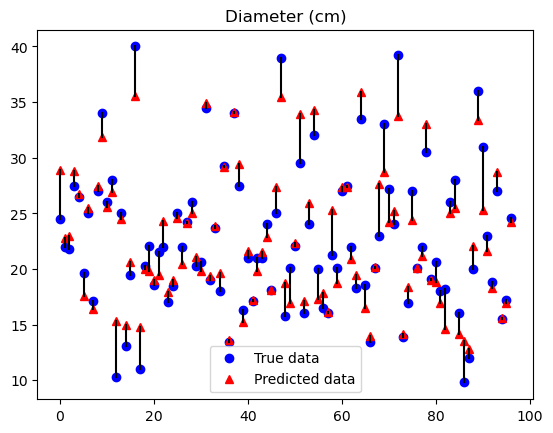

In [77]:
X_train, y_train, X_test, y_test = prepare_data(1,'Diameter',0, True)
model = tf.keras.models.load_model('./checkpoints/rgb_augm_diameter/cp-0052.ckpt')
plot_true_vs_predicted(model, X_test, y_test, 'Diameter (cm)')

Height

4/4 [==============================] - 2s 591ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


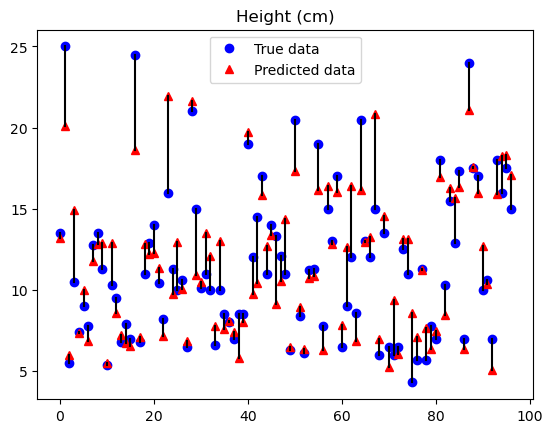

In [78]:
X_train, y_train, X_test, y_test = prepare_data(0,'Height',0, False)
model = tf.keras.models.load_model('./checkpoints/depth_augm_height/cp-0064.ckpt')
plot_true_vs_predicted(model, X_test, y_test, 'Height (cm)')

Fresh Weight

4/4 [==============================] - 2s 552ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


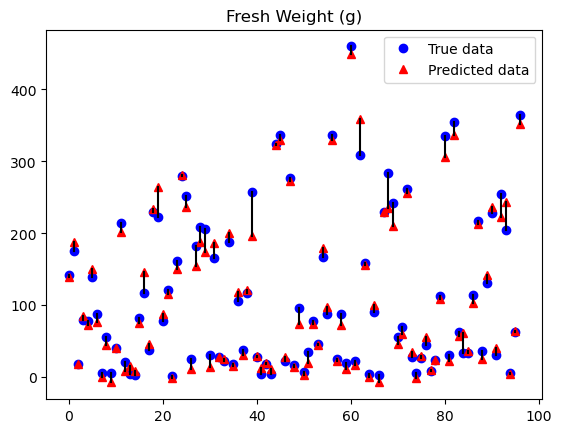

In [79]:
X_train, y_train, X_test, y_test = prepare_data(2,'FreshWeightShoot',0, False)
model = tf.keras.models.load_model('./checkpoints/rgb-d_freshweight/cp-0100.ckpt')
plot_true_vs_predicted(model, X_test, y_test, 'Fresh Weight (g)')

Dry Weight

4/4 [==============================] - 2s 565ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


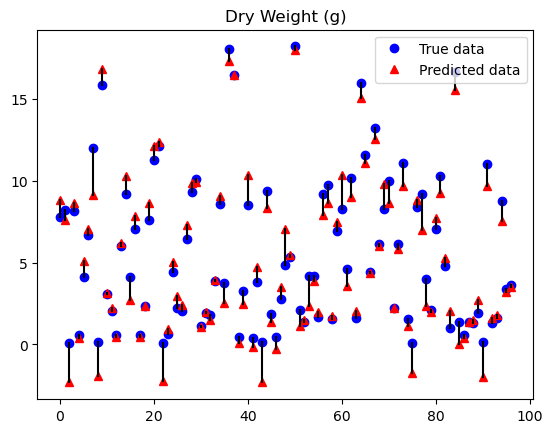

In [80]:
X_train, y_train, X_test, y_test = prepare_data(1,'DryWeightShoot',0, False)
model = tf.keras.models.load_model('./checkpoints/rgb_dryweight/cp-0077.ckpt')
plot_true_vs_predicted(model, X_test, y_test, 'Dry Weight (g)')

Leaf Area

4/4 [==============================] - 2s 565ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


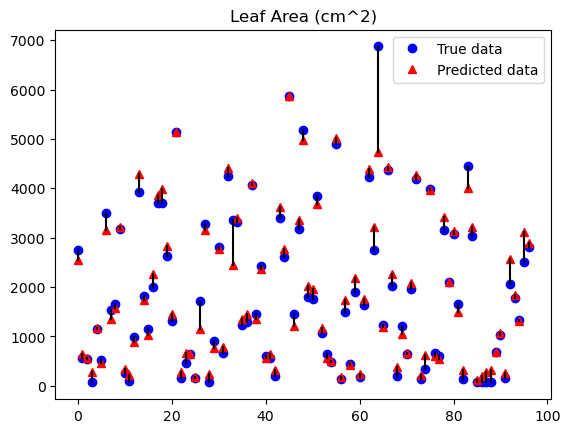

In [81]:
X_train, y_train, X_test, y_test = prepare_data(1,'LeafArea',0, False)
model = tf.keras.models.load_model('./checkpoints/rgb_leafarea/cp-0085.ckpt')
plot_true_vs_predicted(model, X_test, y_test, 'Leaf Area (cm^2)')